Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Section 12.8.2 

Classification of wheat varieties from two properties of their seeds\
Topics and relevant videos: [Classification](https://www.youtube.com/watch?v=pfIPwD2mWbo), [neural networks, deep learning](https://www.youtube.com/watch?v=YxHAyZPnv9o)

Author: Carlos Fernandez-Granda\
Data source: https://archive.ics.uci.edu/dataset/236/seeds

In [1]:
import os.path
import numpy as np
import math
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import urllib.request
import io

font_size = 15
font_size_legend = 15
font_size_ticks = 15
font_size_graph = 15

# Check if MPS is available, if it is, it will be used
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())
device = torch.device("mps")

# dataset = np.loadtxt("../data/seeds_dataset.txt")

url = "https://raw.githubusercontent.com/cfgranda/ps4ds/main/data/seeds_dataset.txt"

with urllib.request.urlopen(url) as response:
    dataset = np.loadtxt(io.TextIOWrapper(response))
    
data = dataset[:,:-1]
labels = dataset[:,-1]-1 # labels are 0, 1 or 2

# Center the columns 
centered_data = data - data.mean(axis=0)
# Normalize each column (divide by standard deviation) to account for difference in units
standardized_data = (centered_data  / centered_data.std(axis=0)).T

MPS available: False
MPS built: False


In [2]:
# We perform classification based on the first and sixth feature
feature_1 = 0
feature_2 = 5
X_train = standardized_data[[feature_1,feature_2],:].T
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.from_numpy(labels).reshape(-1, 1)
n_train = len(labels)
# Set up data loader the for training set
training_loader = DataLoader(list(zip(X_train_tensor, y_train_tensor)), shuffle=True, batch_size=n_train)

In [3]:
# Neural network with one hidden layer with 100 neurons
torch.manual_seed(2024)
n_classes = 3
n_hidden = 100
model = nn.Sequential(
    nn.Linear(2, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_classes)
)

if torch.backends.mps.is_available():
    model = model.to(device)

In [ ]:
# Train the model
n_epochs = 2000
optimizer = optim.Adam(model.parameters(), lr=1e-2)
model.train()
training_error_model = []
test_error_model = []
loss = nn.CrossEntropyLoss()
verbose = False
for epoch in range(n_epochs):
    if verbose:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
    training_aux = 0
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(torch.float32)
        y_batch = torch.flatten(y_batch).to(torch.float32)
        if torch.backends.mps.is_available():
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        if verbose:
            print(X_batch[:3,:])
            print(y_pred[:3])
        training_loss = loss(y_pred, y_batch)
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
    training_error_model.append(training_loss.item())

In [ ]:
tick_aux = np.arange(0,2500,500)
plt.figure(figsize=(5,3))
plt.xticks(tick_aux,fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlabel(r'Epoch',fontsize=font_size,labelpad = 15)
plt.ylabel(r'Training error',fontsize=font_size,labelpad = 15)
plt.plot(training_error_model,color="black",lw=2,
         label="Training")
plt.grid()

In [ ]:
xtick_aux = np.arange(-1,3,1)

max_feature_1 = np.max(X_train[:,0]) + 0.1
max_feature_2 = np.max(X_train[:,1]) + 0.1
min_feature_1 = np.min(X_train[:,0]) - 0.1
min_feature_2 = np.min(X_train[:,1]) - 0.1

n_grid = 100
feature_1_aux = np.linspace(min_feature_1, max_feature_1, n_grid)  
feature_2_aux = np.linspace(min_feature_2, max_feature_2, n_grid) 

feature_1_grid, feature_2_grid = np.meshgrid(feature_1_aux, feature_2_aux)

logits = np.zeros((n_grid,n_grid,n_classes))

for ind_1 in range(n_grid):
    for ind_2 in range(n_grid):
        features = torch.tensor([[feature_1_aux[ind_1], feature_2_aux[ind_2]]]).to(torch.float32)
        if torch.backends.mps.is_available():
            logit_vector = model(features.to(device)).detach().cpu().numpy()
        else:
            logit_vector = model(features).detach().numpy()
        for ind_c in range(n_classes):
            logits[ind_2,ind_1,ind_c] = logit_vector[0][ind_c]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,3),width_ratios=[1,1,1])
varieties = ["Kama","Rosa","Canadian"]
fig.suptitle("Logits",fontsize=font_size,y = 1.1)
    
for ind_c in range(3):

    CS = axes[ind_c].contour(feature_1_aux, feature_2_aux,logits[:,:,ind_c], levels=15,colors='black',linewidths=2,linestyles="dashed")
    plt.clabel(CS, CS.levels, inline=True, fontsize=font_size_ticks-5,inline_spacing=10, rightside_up=True,fmt='%1.1f')
    axes[ind_c].set_xticks(xtick_aux) 
    axes[ind_c].set_xlabel("Area",fontsize=font_size,labelpad=5)
    axes[ind_c].set_title(varieties[ind_c],fontsize=font_size,pad=5)
    if ind_c == 0:
        axes[ind_c].set_ylabel('Asymmetry coefficient',fontsize=font_size,labelpad=5)

In [84]:
probabilities = np.zeros((n_grid,n_grid,n_classes))

for ind_1 in range(n_grid):
    for ind_2 in range(n_grid):
        features = torch.tensor([[feature_1_aux[ind_1], feature_2_aux[ind_2]]]).to(torch.float32)
        if torch.backends.mps.is_available():
            logit_vector = model(features.to(device)).detach().cpu()
        else:
            logit_vector = model(features).detach()
        probability_vector = torch.softmax(logit_vector,1).detach().numpy()
        for ind_c in range(n_classes):
            probabilities[ind_2,ind_1,ind_c] = probability_vector[0][ind_c]

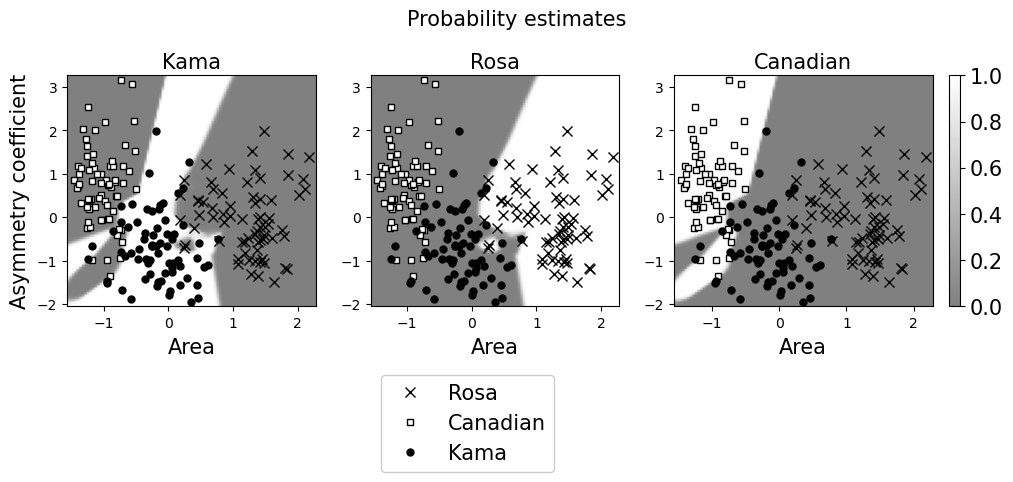

In [85]:
msize=5
medgewidth=1

fig, axes = plt.subplots(1, 3, figsize=(12,3),width_ratios=[1,1,1.3])
fig.suptitle("Probability estimates",fontsize=font_size,y = 1.1)

for ind_c in range(3):

    im = axes[ind_c].imshow(probabilities[:,:,ind_c], cmap='gray', vmin=-1, vmax=1,
                    extent=[min_feature_1,max_feature_1,min_feature_2, max_feature_2],
                    origin='lower', aspect='auto')
    axes[ind_c].plot(standardized_data[feature_1,:][labels==1],standardized_data[feature_2,:][labels==1], markersize=msize+2, 
             c="black", marker='x', markeredgewidth=medgewidth,
                 linestyle = 'None',markeredgecolor="black",label="Rosa")
    axes[ind_c].plot(standardized_data[feature_1,:][labels==2],standardized_data[feature_2,:][labels==2], markersize=msize, 
             color="white", marker='s', markeredgewidth=medgewidth,
                linestyle = 'None',markeredgecolor="black",label="Canadian")
    axes[ind_c].plot(standardized_data[feature_1,:][labels==0],standardized_data[feature_2,:][labels==0], markersize=msize, 
             color="black", marker='o', markeredgewidth=medgewidth,
                 linestyle = 'None',markeredgecolor="black",label="Kama")
    if ind_c==1:
        axes[ind_c].legend(fontsize=font_size_legend,framealpha=1,bbox_to_anchor=(0, -0.25), loc='upper left', ncol=1)
    axes[ind_c].set_xticks(xtick_aux) 
    axes[ind_c].set_xlabel("Area",fontsize=font_size,labelpad=5)
    if ind_c==0:
        axes[ind_c].set_ylabel('Asymmetry coefficient',fontsize=font_size,labelpad=5)
    axes[ind_c].set_title(varieties[ind_c],fontsize=font_size,pad=5)
    
cbar = plt.colorbar(im)
cbar.ax.set_ylim(0, 1.0)
cbar.ax.tick_params(labelsize=font_size_ticks)